In [64]:
import xarray as xr
import datetime
import pymannkendall as mk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# load landcover and anette's landcover! (first normal landcover)
land_cover = xr.open_dataset('/mnt/data7/nfs4/avh_ndvi/sdupuis/ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7b.nc', engine='netcdf4')

In [3]:
lc = land_cover.sel(lat=slice(72,55), lon=slice(-168,-150))

In [4]:
alaska_anoms = xr.open_dataset('standard_anomalies_alaska_NIGHT.nc')

In [6]:
lc_interp = lc.interp(lat=alaska_anoms.coords['lat'], lon=alaska_anoms.coords['lon'], method='nearest')

In [5]:
alaska_anoms

<xarray.Dataset>
Dimensions:      (lat: 800, lon: 7200, time: 446)
Coordinates:
  * lat          (lat) float32 50.03 50.08 50.12 50.17 ... 89.88 89.93 89.97
  * lon          (lon) float32 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
    band         int64 ...
    spatial_ref  int64 ...
  * time         (time) datetime64[ns] 1981-08-01 1981-09-01 ... 2018-12-01
    month        (time) int64 ...
Data variables:
    LST          (lat, lon, time) float32 ...

In [9]:
subset = alaska_anoms.sel(lat=slice(55,72), lon=slice(-168,-150))

In [36]:
subset["LST"].std()

<xarray.DataArray 'LST' ()>
array(0.98587608)
Coordinates:
    band         int64 1
    spatial_ref  int64 0

In [15]:
subset

<xarray.Dataset>
Dimensions:      (lat: 340, lon: 360, time: 446)
Coordinates:
  * lat          (lat) float32 55.03 55.08 55.12 55.17 ... 71.88 71.93 71.97
  * lon          (lon) float32 -168.0 -167.9 -167.9 ... -150.1 -150.1 -150.0
    band         int64 1
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 1981-08-01 1981-09-01 ... 2018-12-01
    month        (time) int64 ...
Data variables:
    LST          (lat, lon, time) float32 nan nan nan nan ... nan nan nan nan

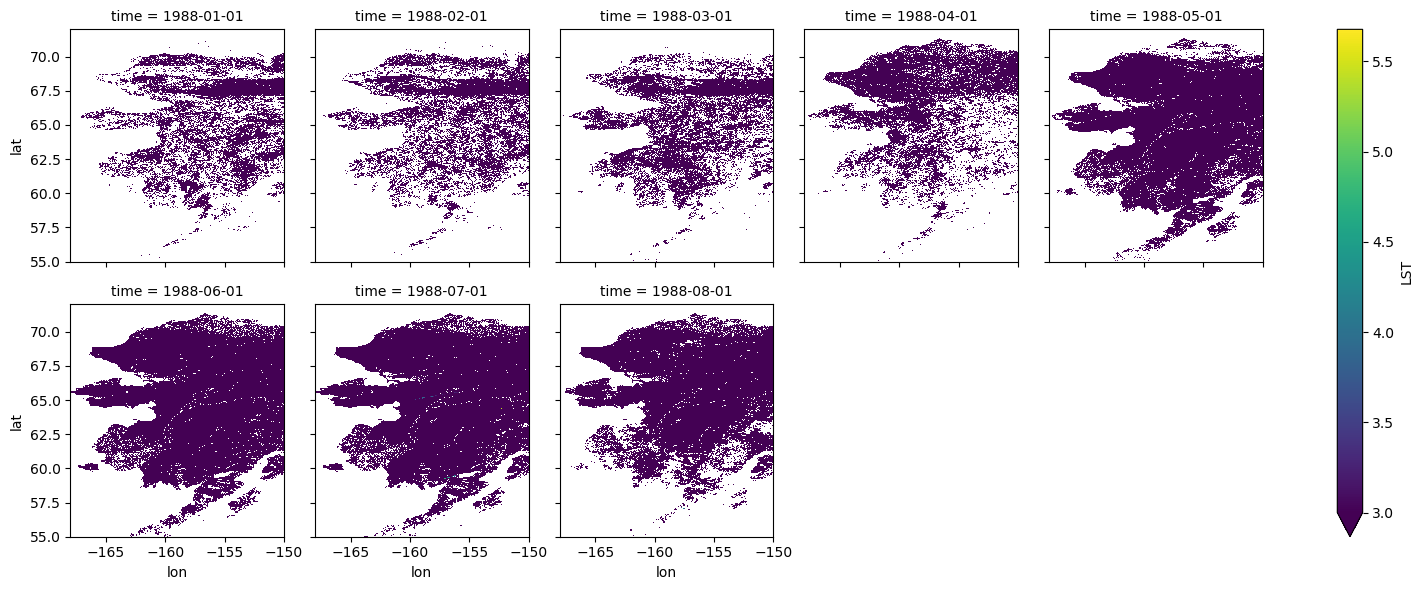

In [90]:
subset['LST'].sel(lat=slice(55,72), lon=slice(-168,-150), time=slice('1988-01','1988-08')).plot(x="lon", y="lat", col="time", col_wrap=5, vmin=3);

In [ ]:
# remove swat line effects -> above 3 std is a problem
# remove nb of observations

In [48]:
n_valid = subset['LST'].count(dim="time")

In [50]:
n_valid = n_valid.where(lc_interp['lccs_class'] != 210)

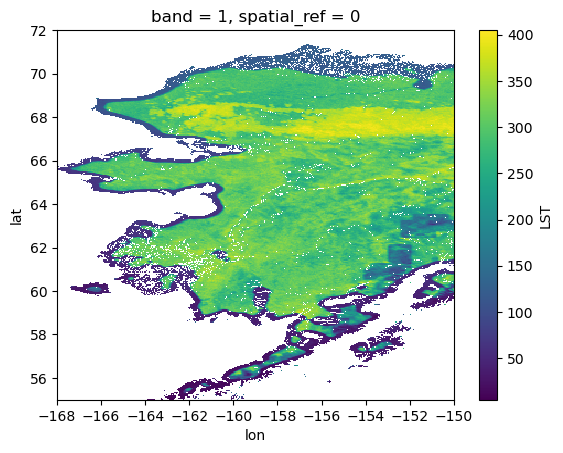

In [ ]:
n_valid.plot();
# below 100 is a threshold

In [42]:
above_1 = (subset['LST'] > 1.5).sum(dim="time")
below_minus1 = (subset['LST'] < -1.5).sum(dim="time")

In [ ]:
# compute proportion of pixels?

In [44]:
below_minus1 = below_minus1.where(lc_interp['lccs_class'] != 210)

In [45]:
above_1 = above_1.where(lc_interp['lccs_class'] != 210)

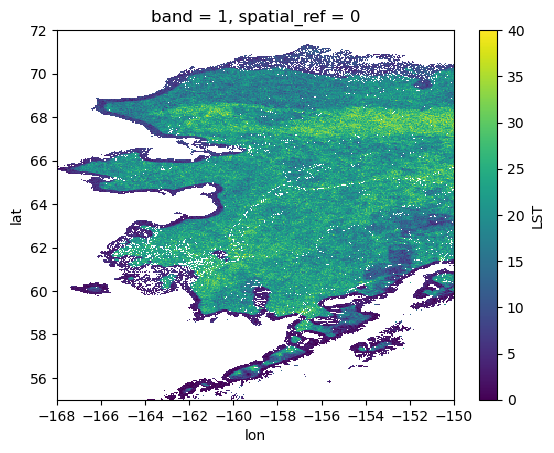

In [46]:
below_minus1.plot();

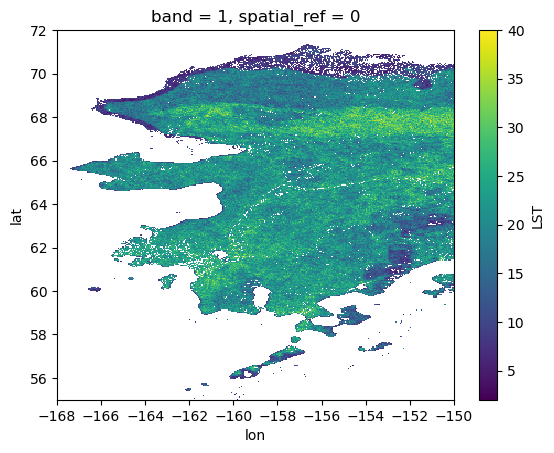

In [53]:
below_minus1.where(n_valid>100).plot();

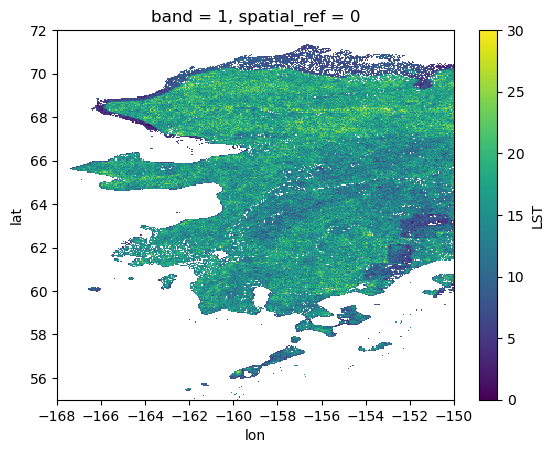

In [54]:
above_1.where(n_valid>100).plot();

In [92]:
def prep_dataset(path, lat_tuple, lon_tuple):
    ds = xr.open_dataset(path)
    land_cover = xr.open_dataset('/mnt/data7/nfs4/avh_ndvi/sdupuis/ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7b.nc', engine='netcdf4')
    lc = land_cover.sel(lat=slice(lat_tuple[0], lat_tuple[1]), lon=slice(lon_tuple[0], lon_tuple[1]))
    lc_interp = lc.interp(lat=ds.coords['lat'], lon=ds.coords['lon'], method='nearest')
    subset = ds.sel(lat=slice(lat_tuple[1], lat_tuple[0]), lon=slice(lon_tuple[0], lon_tuple[1]))
    n_valid = subset['LST'].count(dim="time")
    n_valid = n_valid.where(lc_interp['lccs_class'] != 210)
    above_1 = ((subset['LST'] > 1.5) & (subset['LST'] < 3.0)).sum(dim="time")
    below_minus1 = ((subset['LST'] < -1.5) & (subset['LST'] > -3.0)).sum(dim="time")
    below_minus1 = below_minus1.where(lc_interp['lccs_class'] != 210)
    above_1 = above_1.where(lc_interp['lccs_class'] != 210)
    below_minus1= below_minus1.where(n_valid>100)
    above1 = above_1.where(n_valid>100)

    return above1, below_minus1


In [85]:
def map_landcover(df):

    lc_group_map = {
    # 1. Agriculture
    10: "Crop",
    11: "Crop",
    20: "Crop",
    30: "Crop",
    40: "Crop",

    # 2. Forest
    50: "EBF",
    60: "DBF", 61: "DBF", 62: "DBF",
    70: "ENF", 71: "ENF", 72: "ENF",
    80: "DNF", 81: "DNF", 82: "DNF",
    90: "MF",
    100: "MF",
    160: "FF",
    170: "FF",

    # 3. Grassland
    110: "Grass",
    130: "Grass",

    # 4. Wetland
    180: "Wet",

    # 5. Settlement
    190: "Settlement",

    # 6. Other (Shrubland / Sparse / Bare / Water)
    120: "Shrub",
    121: "Shrub",
    122: "Shrub",
    140: "Lichens",
    150: "Sparse",
    151: "Sparse",
    152: "Sparse",
    153: "Sparse",
    200: "Bare",
    201: "Bare",
    202: "Bare",
    220: "Ice"
    }

    df["landcover_group"] = df["landcover"].map(lc_group_map)
    # filter classes with very low samples
    counts = df["landcover_group"].value_counts()
    valid_classes = counts[counts > 20].index

    df = df[df["landcover_group"].isin(valid_classes)]
    return df


In [138]:
# link to land cover ? Day and Night -> check with air temperature
def df_creation(ds):

    land_cover = xr.open_dataset('/mnt/data7/nfs4/avh_ndvi/sdupuis/ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7b.nc', engine='netcdf4')
    lc = land_cover.sel(lat=slice(lat_tuple[0], lat_tuple[1]), lon=slice(lon_tuple[0], lon_tuple[1]))
    lc_interp = lc.interp(lat=ds.coords['lat'], lon=ds.coords['lon'], method='nearest')
    data = ds.where(~np.isnan(lc_interp['lccs_class']))
    landcover = lc_interp.where(~np.isnan(ds))
    trend_1d = data.stack(points=("lat", "lon"))
    lc_1d = landcover['lccs_class'].stack(points=("lat", "lon"))

    valid = (~np.isnan(trend_1d)) & (~np.isnan(lc_1d))
    trend_1d = trend_1d[valid]
    lc_1d = lc_1d[valid]
    df = pd.DataFrame({
    "trend": trend_1d.values,
    "landcover": lc_1d.values.astype(int)
    })

    df_filtered = map_landcover(df)
    return df_filtered


In [108]:
above_anoms_d, below_anoms_d = prep_dataset('standard_anomalies_alaska_day.nc',(72,55), (-168,-150) )

In [109]:
above_anoms_n, below_anoms_n = prep_dataset('standard_anomalies_alaska_NIGHT.nc',(72,55), (-168,-150) )

In [139]:
anom_df_below_n = df_creation(below_anoms_n)

NameError: name 'lat_tuple' is not defined

In [114]:
anom_df_above1_d = df_creation(above_anoms_d)

In [113]:
anom_df_below_d = df_creation(below_anoms_d)
anom_df_above1_n = df_creation(above_anoms_n)

In [117]:
result_anoms_alaska = (
    pd.concat(
        [anom_df_above1_d, anom_df_above1_n , anom_df_below_d,anom_df_below_n],
        keys=["Day_positive", "Night_positive", "Day_negative", "Night_negative"],
        names=["Datasets"]
    )
    .reset_index(level="Datasets")
)

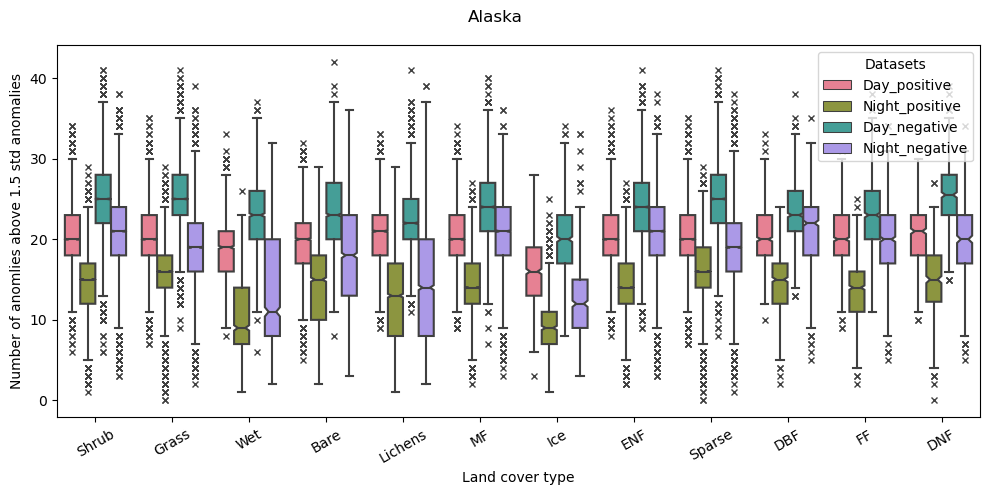

In [121]:
# Group all boxplots
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=result_anoms_alaska,
    x="landcover_group",   # or "landcover"
    y="trend",
    hue='Datasets',
    palette = 'husl',
    notch=True,
    flierprops={"marker":"x"}
)

plt.ylabel("Number of anomlies above 1.5 std anomalies")
plt.xlabel("Land cover type")
plt.suptitle('Alaska')
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig('Alaska_box_plot_anomalies.png')
plt.show()

In [123]:
# Greenland
above_anoms_d, below_anoms_d = prep_dataset('standard_anomalies_Greenland_day.nc',(84,58), (-73,-7) )

#lat=slice(84,58), lon=slice(-73,-7)

In [124]:
above_anoms_n, below_anoms_n = prep_dataset('standard_anomalies_Greenland_NIGHT.nc',(84,58), (-73,-7) )

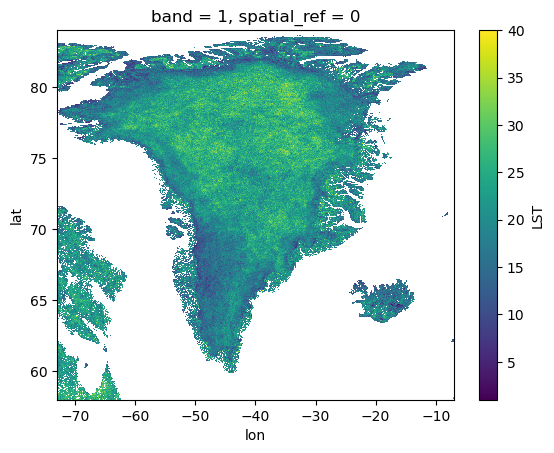

In [135]:
above_anoms_d.plot()

In [125]:
anom_df_below_n = df_creation(below_anoms_n)
anom_df_above1_d = df_creation(above_anoms_d)
anom_df_below_d = df_creation(below_anoms_d)
anom_df_above1_n = df_creation(above_anoms_n)

In [130]:
anom_df_below_d

,trend,landcover,landcover_group


In [126]:
result_anoms_greenland = (
    pd.concat(
        [anom_df_above1_d, anom_df_above1_n , anom_df_below_d,anom_df_below_n],
        keys=["Day_positive", "Night_positive", "Day_negative", "Night_negative"],
        names=["Datasets"]
    )
    .reset_index(level="Datasets")
)

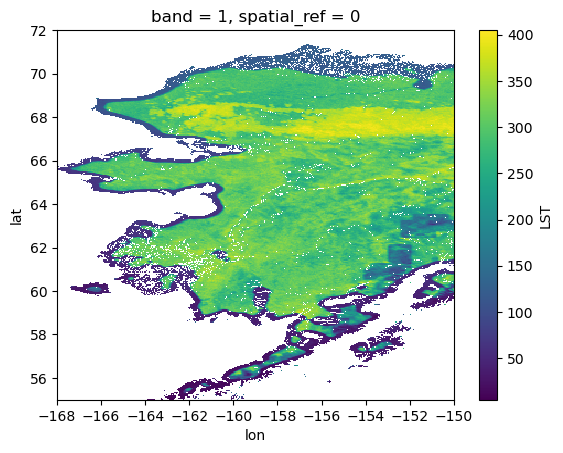

In [132]:
n_valid.plot()

In [128]:
result_anoms_greenland

,Datasets,trend,landcover,landcover_group


In [127]:
# Group all boxplots
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=result_anoms_greenland,
    x="landcover_group",   # or "landcover"
    y="trend",
    hue='Datasets',
    palette = 'husl',
    notch=True,
    flierprops={"marker":"x"}
)

plt.ylabel("Number of anomlies above 1.5 std anomalies")
plt.xlabel("Land cover type")
plt.suptitle('Greenland')
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig('Greenland_box_plot_anomalies.png')
plt.show()

ValueError: min() arg is an empty sequence

<Figure size 1000x500 with 0 Axes>

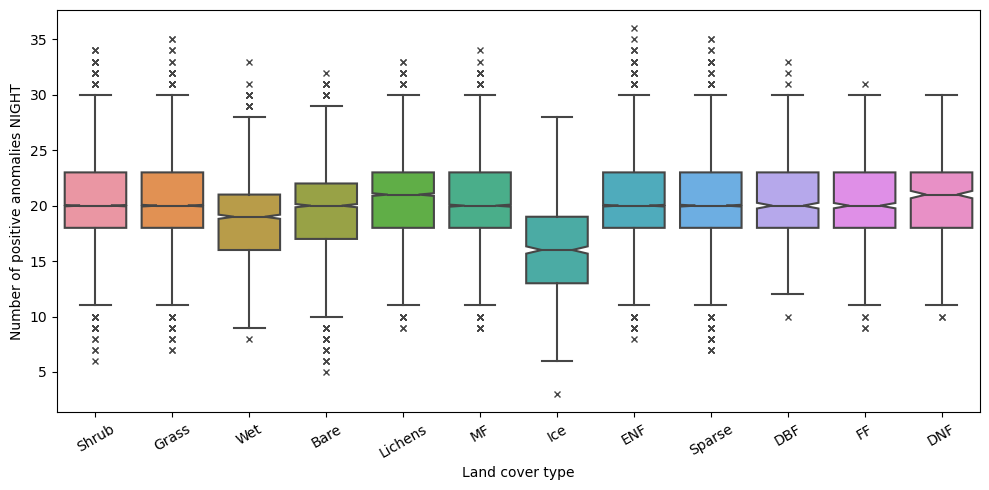

In [107]:
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=anom_df_above1,
    x="landcover_group",   # or "landcover"
    y="trend",
    notch=True,
    flierprops={"marker":"x"}
)

plt.ylabel("Number of positive anomalies NIGHT")
plt.xlabel("Land cover type")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()
# sorted by count -> maybe change the colors